In [3]:
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
df = pd.read_csv('../dataset/raw_dataset.csv')
df.describe()

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,taken
count,1.469870e+05,1.469870e+05,146987.000000,146987.000000,146987.000000,146987.000000
mean,1.507718e+07,7.580708e+08,1.501015,26.899130,5358.641594,0.921218
std,4.750119e+05,3.214280e+08,0.845776,84.907724,1779.800955,0.269400
min,1.421073e+07,3.000000e+07,0.000000,-598.296875,0.000000,0.000000
25%,1.466969e+07,9.000045e+08,0.836511,-18.348755,4200.000000,1.000000
50%,1.509241e+07,9.000077e+08,1.390230,11.145264,5200.000000,1.000000
75%,1.547355e+07,9.000127e+08,2.029955,61.024353,6300.000000,1.000000
max,1.590252e+07,9.000173e+08,9.360177,1009.380005,108200.000000,1.000000


In [5]:
df['created_at'] = pd.to_datetime(df['created_at'])
print(df['created_at'].min())
print(df['created_at'].max())

2017-09-05 00:01:02+00:00
2017-10-04 23:58:53+00:00


In [ ]:
df.astype(bool).sum(axis=0)
df.isnull().sum()
df[df.store_id==900015404].head(10)
df.sort_values("to_user_elevation", ascending=True).head(20)

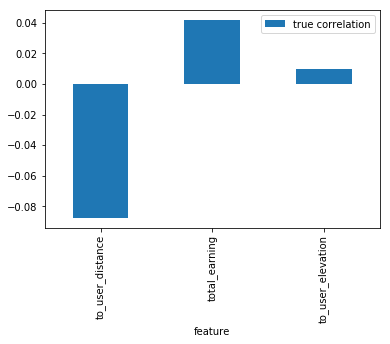

In [23]:
features = ['to_user_distance','to_user_elevation','total_earning','taken']

# Features correlation coefficent to label
fi = pd.DataFrame({'feature': features,
                   'correlation': df[features].corr()['taken'].abs(),
                   'true correlation': df[features].corr()['taken']
                  }).sort_values('correlation', ascending = False)

fi[fi.feature!='taken'].head(10).plot.bar(x='feature', y ='true correlation')

In [179]:
df['year'] = pd.to_datetime(df['created_at']).apply(lambda x: '{year}'.format(year=x.year)).astype(int)
df['month'] = pd.to_datetime(df['created_at']).apply(lambda x: '{month}'.format(month=x.month)).astype(int)
df['day'] = pd.to_datetime(df['created_at']).apply(lambda x: '{day}'.format(day=x.day)).astype(int)
df['dayofweek'] = pd.to_datetime(df['created_at']).apply(lambda x: '{dayofweek}'.format(dayofweek=x.dayofweek)).astype(int)

In [131]:
grouped = df[['year','month','day','taken']][df.taken==1].groupby(by=['year','month','day']).count()
grouped.sort_values(by=['year','month','day'], ascending=True )

taken
year month day       
2017 9     5     3404
           6     3576
           7     3747
           8     5488
           9     4922
           10    6451
           11    3221
           12    2998
           13    3576
           14    3647
           15    4582
           16    5671
           17    7083
           18    3275
           19    3553
           20    3472
           21    3682
           22    4947
           23    6057
           24    7517
           25    4100
           26    6484
           27    3170
           28    3835
           29    4343
           30    5608
     10    1     7247
           2     3096
           3     3091
           4     3564

In [132]:
grouped['not_taken'] = df[['year','month','day','taken']][df.taken==0].groupby(by=['year','month','day']).count()
grouped['total'] = grouped.not_taken + grouped.taken
grouped['rate'] = grouped.not_taken/grouped.total
grouped = grouped.reset_index()

In [135]:
grouped['date'] = grouped.year.astype(str) + '-' + grouped.month.astype(str) + '-' + grouped.day.astype(str)
grouped['date'] = pd.to_datetime(grouped.date)

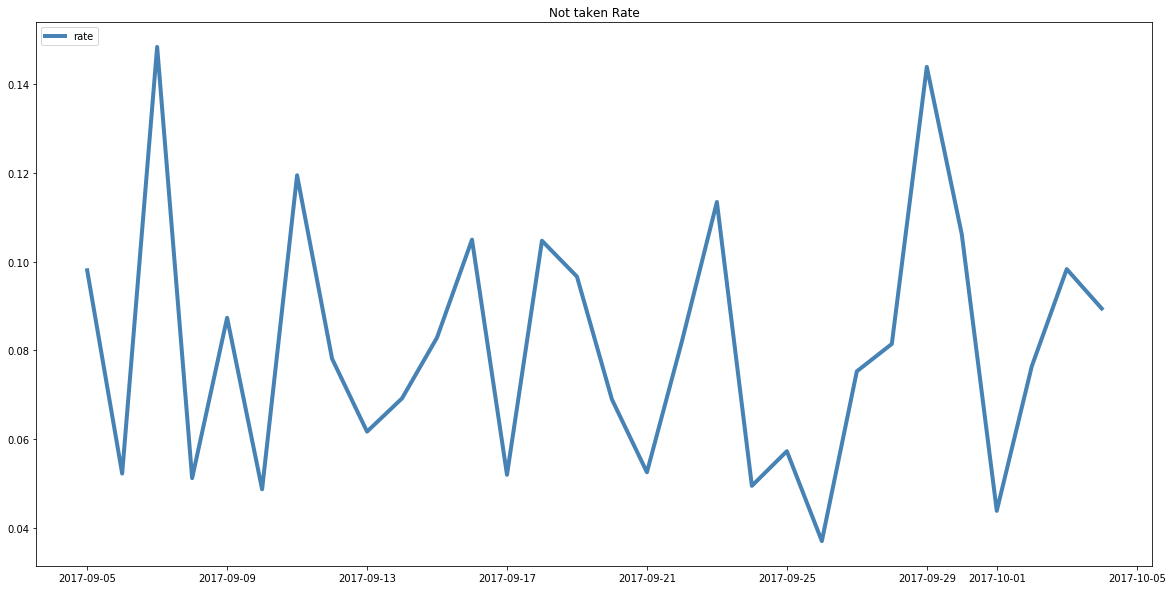

In [142]:
plt.figure(figsize=(20, 10))
plt.title('Not taken Rate')
plt.xticks(size = 10)
plt.plot(grouped.date, grouped.rate, c='steelblue', linewidth=4, zorder=10)
plt.legend(loc='upper left')
plt.show()


In [193]:
grouped_store = df[['store_id','taken']][df.taken==1].groupby(by=['store_id']).count().fillna(0)
grouped_store['not_taken'] = df[['store_id','taken']][df.taken==0].groupby(by=['store_id']).count()
grouped_store['not_taken'] = grouped_store['not_taken'].fillna(0)
grouped_store['total'] = grouped_store.not_taken + grouped_store.taken
grouped_store['rate'] = grouped_store.not_taken/grouped_store.total
grouped_store = grouped_store.reset_index()

grouped_store[grouped_store.total>5].sort_values('rate', ascending=False).head(10)

,store_id,taken,not_taken,total,rate
740,900015880,3,9.0,12.0,0.750000
345,900010618,9,12.0,21.0,0.571429
660,900015092,7,8.0,15.0,0.533333
833,900017244,4,4.0,8.0,0.500000
625,900014635,6,5.0,11.0,0.454545
562,900013831,6,5.0,11.0,0.454545
274,900008544,14,11.0,25.0,0.440000
531,900013366,17,12.0,29.0,0.413793
671,900015231,37,26.0,63.0,0.412698
724,900015739,10,7.0,17.0,0.411765


In [184]:
grouped_dayw = df[['dayofweek','taken']][df.taken==1].groupby(by=['dayofweek']).count().fillna(0)
grouped_dayw['not_taken'] = df[['dayofweek','taken']][df.taken==0].groupby(by=['dayofweek']).count()
grouped_dayw['not_taken'] = grouped_dayw['not_taken'].fillna(0)
grouped_dayw['total'] = grouped_dayw.not_taken + grouped_dayw.taken
grouped_dayw['rate'] = grouped_dayw.not_taken/grouped_dayw.total
grouped_dayw = grouped_dayw.reset_index()


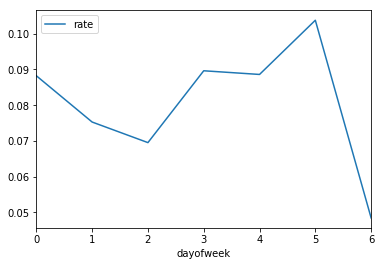

In [187]:
grouped_dayw.plot('dayofweek','rate')

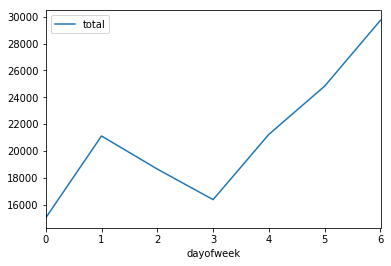

In [188]:
grouped_dayw.plot('dayofweek','total')

In [ ]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)
df.to_sql('carriers', con=engine)


In [ ]:
query = '''
select 
    store_id, 
    count(1) as "qty", 
    100.00*sum(case when taken=0 then 1 else 0 end)/count(1) 
from 
    carriers 
where 1=1
group by 
    store_id 
having 
    count(1)>5
order by 
    3 desc    and (select count(1) from carriers c2 where c.store_id=c2.store_id and taken=0 and c2.created_at<c.created_at)>5

'''
engine.execute(query).fetchall()


In [6]:
import sqlite3
conn = sqlite3.connect('test.db')
df.to_sql('carriers',conn, if_exists='append')
, 900017107, 900014451)

In [27]:

query = '''
select 
    c.order_id,
    c.store_id,
    count(distinct order_id),
    sum(case when c2.taken=0 then 1 else 0 end),
    round(1.00*sum(case when c2.taken=0 then 1 else 0 end)/count(distinct order_id)),2)
from 
    carriers c
    left outer join carriers c2 on c2.store_id=c.store_id 
        and c2.order_id<>c.order_id 
        and c2.created_at < c.created_at 
        and Cast((JulianDay(c.created_at) - JulianDay(c2.created_at)) As Integer)<5
where 1=1
group by 
     c.order_id, 
     c.store_id 
order by 
    3 desc
'''
result = conn.cursor().execute(query).fetchall()
result

[(15047962, 900009494, 719, 102, 0.14),
 (15048263, 900009494, 719, 102, 0.14),
 (15046721, 900009494, 718, 101, 0.14),
 (15047772, 900009494, 718, 102, 0.14),
 (15042751, 900009494, 717, 98, 0.14),
 (15046632, 900009494, 717, 101, 0.14),
 (15047211, 900009494, 717, 102, 0.14),
 (15047686, 900009494, 717, 102, 0.14),
 (15040975, 900009494, 716, 99, 0.14),
 (15041398, 900009494, 716, 99, 0.14),
 (15041549, 900009494, 716, 98, 0.14),
 (15041874, 900009494, 716, 98, 0.14),
 (15042241, 900009494, 716, 98, 0.14),
 (15042487, 900009494, 716, 98, 0.14),
 (15043603, 900009494, 716, 97, 0.14),
 (15043755, 900009494, 716, 97, 0.14),
 (15043951, 900009494, 716, 97, 0.14),
 (15044003, 900009494, 716, 97, 0.14),
 (15046456, 900009494, 716, 101, 0.14),
 (15046901, 900009494, 716, 101, 0.14),
 (15050259, 900009494, 716, 102, 0.14),
 (15051113, 900009494, 716, 101, 0.14),
 (15053706, 900009494, 716, 103, 0.14),
 (15040600, 900009494, 715, 98, 0.14),
 (15046274, 900009494, 715, 101, 0.14),
 (15049094, 

In [35]:
pd.DataFrame(result).fillna(0)

,0,1,2,3,4
0,15047962,900009494,719,102,0.14
1,15048263,900009494,719,102,0.14
2,15046721,900009494,718,101,0.14
3,15047772,900009494,718,102,0.14
4,15042751,900009494,717,98,0.14
5,15046632,900009494,717,101,0.14
6,15047211,900009494,717,102,0.14
7,15047686,900009494,717,102,0.14
8,15040975,900009494,716,99,0.14
9,15041398,900009494,716,99,0.14


In [29]:
df[df.store_id==30000017].sort_values('created_at')

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken
107296,14444354,30000017,0.638897,3.669189,6500,2017-09-08 20:47:11+00:00,1
58213,14624333,30000017,1.073732,-38.589844,3700,2017-09-11 21:30:05+00:00,0
84038,15389179,30000017,1.073732,-38.589844,7200,2017-09-25 19:49:58+00:00,1
120321,15499309,30000017,1.225479,8.617798,5200,2017-09-27 19:36:58+00:00,1
83509,15499520,30000017,0.638897,3.669189,5200,2017-09-27 19:40:04+00:00,0
142215,15793386,30000017,0.940078,-35.997070,3200,2017-10-02 19:17:13+00:00,1
138400,15886332,30000017,0.638897,3.669189,4200,2017-10-04 18:48:06+00:00,1


In [ ]:
result